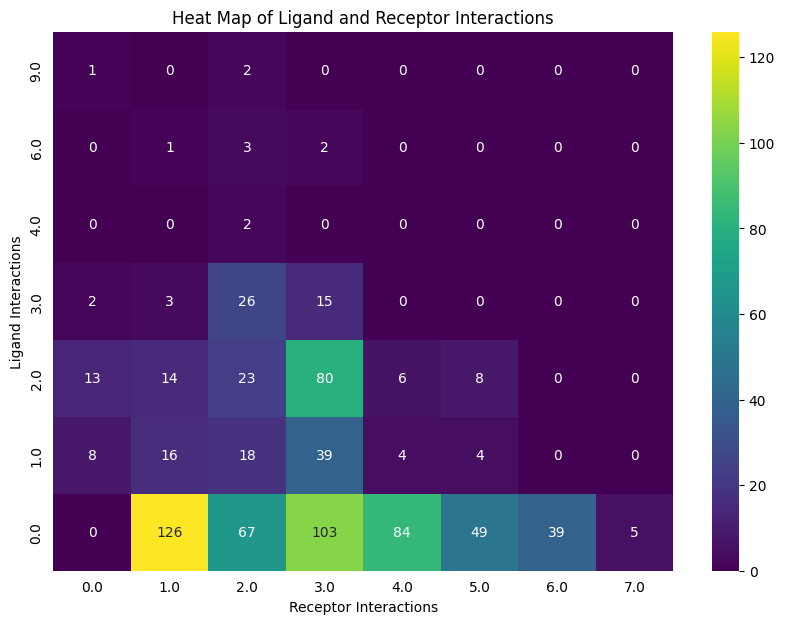

In [144]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

csv_file_path = 'interaction_counts.csv'
df = pd.read_csv(csv_file_path)

# Group by ligand_interactions and receptor_interactions and count entries
# Create a pivot table
pivot_table = df.pivot(index='num_lig_int', columns='num_receptor_int', values='count')
pivot_table = pivot_table.fillna(0)
pivot_table = pivot_table.astype(int)

# Plot the heatmap
plt.figure(figsize=(10, 7))
heatmap = sns.heatmap(pivot_table, annot=True, fmt='d', cmap='viridis')
plt.gca().invert_yaxis()
plt.tick_params(left=False, bottom=False)
plt.title('Heat Map of Ligand and Receptor Interactions')
plt.xlabel('Receptor Interactions')
plt.ylabel('Ligand Interactions')
plt.show()


In [148]:
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

def graph_ca_interaction(row,title="NA"): 
    '''Input: A row, representing a calcium ion in a given structure, containing these infos in this format
    cul_row = {
    'atom_ResName': 'CA',
    'atom_Serial': 0,
    'atom_name': 'CA',
    'file_name': 'aligned',
    'ligand_interactions': [],
    'receptor_interactions': [],
    'num_lig_int': 2.0,
    'num_receptor_int': 3.0
}
    atom_Serial, file_name are respectively the calcium ion id and the title of desired graph
    The interactions must be in format of a list of np.array. Those straight from the excel are of str
    '''    
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
        
    x_coords = [0]
    y_coords = [0]
    z_coords = [0]
    
    colors = ["r"]
    sizes = [100]
    for atom in row['ligand_interactions']:
        x, y, z = atom
        ax.plot([0, x], [0, y], [0, z], color='b')
        x_coords.append(x)
        y_coords.append(y)
        z_coords.append(z)
        colors.append('b')
        sizes.append(20)
    
    # Process receptor interactions
    for atom in row['receptor_interactions']:
        x, y, z = atom
        ax.plot([0, x], [0, y], [0, z], color='g')
        x_coords.append(x)
        y_coords.append(y)
        z_coords.append(z)
        colors.append('g')
        sizes.append(20)

    # Plot the points with specified colors and sizes
    sc = ax.scatter(x_coords, y_coords, z_coords, c=colors, s=sizes, marker='o')
    
    # Setting labels
    ax.set_xlabel('X axis')
    ax.set_ylabel('Y axis')
    ax.set_zlabel('Z axis')
    ax.set_xlim(-3, 3)
    ax.set_ylim(-3, 3)
    ax.set_zlim(-3, 3)
    
    # Set the title
    if title=="NA":
        ax.set_title(row['file_name'][-8:-4]+" "+"CA"+str(row['atom_Serial']))
        fig.savefig(row['file_name'][-8:-4]+" "+str(row['atom_Serial'])+'.png', dpi=300)
    else:
        ax.set_title(title)
        fig.savefig(title+'.png', dpi=300)
    # Show the plot
    #plt.show()
    

# Uncomment and modify the following line to call the function if needed
# graph_ca_interaction()


In [149]:
csv_file_path = 'calcium_analysis.csv'
df = pd.read_csv(csv_file_path)
for index, row in df.iterrows():
    if row["num_lig_int"]==0 or row["num_receptor_int"]==0:
            continue
    row['ligand_interactions']=eval(row['ligand_interactions'])
    row['receptor_interactions']=eval(row['receptor_interactions'])
    #graph_ca_interaction(row)

In [162]:
###Vectors Stuff
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import ast



def rotation_matrix_from_vectors(vec1, vec2):
    """ Given two vectors in np.array format, find the matrix that transforms vector 1 so that it align with vector 2, 
    returns a rotation matrix
    """
    a, b = (vec1 / np.linalg.norm(vec1)).reshape(3), (vec2 / np.linalg.norm(vec2)).reshape(3)
    v = np.cross(a, b)
    c = np.dot(a, b)
    s = np.linalg.norm(v)
    kmat = np.array([[0, -v[2], v[1]], [v[2], 0, -v[0]], [-v[1], v[0], 0]])
    rotation_matrix = np.eye(3) + kmat + kmat @ kmat * ((1 - c) / (s ** 2))
    return rotation_matrix

def get_normal_vector(plane_coords):
    '''
    Given a list of np.array coordinates representing a plane (i.e 3 3d points)
    find the normal vector of that plane
    '''
    v1 = plane_coords[2] - plane_coords[0]
    v2 = plane_coords[1] - plane_coords[0]
    normal = np.cross(v1, v2)
    normal = normal / np.linalg.norm(normal)
    return normal

def string_to_nparraylist(list_coords_str):
    '''
    Input: A string representing a list of coordinates tuple
    Returns a list of np array coordinates'''
    list_str_coords=ast.literal_eval(list_coords_str)
    list_np_array=[]
    for coord in list_str_coords:
        new_coord=np.array(coord)
        list_np_array.append(new_coord)
    return list_np_array

def calculate_distance_from_origin(points):
    """Given a list of coordinates, calculate their distances from the origin
    Returns a list of distances"""
    return np.linalg.norm(points, axis=1)
def test_coords(originals,transformed):
    '''
    check if the distances of each point from origin before and after transformation are unchanged
    '''
    # print("OG",originals)
    # print("trans",transformed)
    # print(calculate_distance_from_origin(originals),calculate_distance_from_origin(transformed))
    #are_distances_same_list = [np.allclose(d_before, d_after) for d_before, d_after in zip(originals, transformed)]
    are_dist_same = np.allclose(calculate_distance_from_origin(originals),calculate_distance_from_origin(transformed))
    if are_dist_same==False:
        print("test_failed")
        return -1

    return 1


def align_coordinates(ligand_ints,rec_ints):
    '''
    Take in two lists of interactions, transform all list so that 
    first: the plane made by the three receptor interactions are aligned to the xy plane
    second: the line made by the origin and the middle receptor interaction aligns with the x axis'''
    #turns the list string into np array list
    ligand_np_arrays=ligand_ints
    rec_np_arrays=rec_ints
    x=np.array((1,0,0))
    z=np.array((0,0,1))
    rec_plane_normal=get_normal_vector(rec_np_arrays)

    #test first rotation
    plane_to_z=rotation_matrix_from_vectors(rec_plane_normal, z)
    rec_np_arrays_to_z=[]
    for point in rec_np_arrays:
        rec_np_arrays_to_z.append(plane_to_z @ point)
        
    
    #test second rotation
    vector=rec_np_arrays_to_z[1]
    vector[2]=0
    origin_pt_to_x = rotation_matrix_from_vectors(vector, x)
    #get temp final transfomation
    final_transform=origin_pt_to_x @ plane_to_z
    
    rec_np_arrays_final=[]
    for point in rec_np_arrays:
        temp_pt=final_transform @ point
        rec_np_arrays_final.append(-temp_pt)
    #reflects point through xz plane        
    rotate_about_z_180 = np.array([
        [1, 0, 0],
        [0, -1, 0],
        [0, 0, 1]
    ])
    #reflects point through xy plane   
    flip_through_xy= np.array([
        [1, 0, 0],
        [0, 1, 0],
        [0, 0, -1]
    ])
    
    #get final total transformation
    if rec_np_arrays_to_z[0][2]>0:
        final_transform=flip_through_xy @ final_transform
    if rec_np_arrays_final[1][0]<0:
        final_transform=rotate_about_z_180 @ final_transform

    #transforming all pts officially
    trans_rec=[]
    trans_lig=[]

    for point in rec_np_arrays:
        trans_rec.append(final_transform @ point)
    for point in ligand_np_arrays:
        trans_lig.append(final_transform @ point)
        
    #test the validity and the conservatiness of the transformation    
    if test_coords(rec_np_arrays,trans_rec)==1 and trans_rec[1][0]>0:
        return trans_lig, trans_rec
    else:
        print(rec_np_arrays_final[1])
        print(trans_rec[1])
        return -1

In [163]:
import plotly.graph_objects as go
import numpy as np


def graph_interactive(row,title="NA"):
    # Convert coordinates to numpy arrays for convenience
    coords_blue = row['ligand_interactions']
    coords_green = row['receptor_interactions']
    fig = go.Figure()

    #Ligand Interactions
    x_blue = [point[0] for point in coords_blue]
    y_blue = [point[1] for point in coords_blue]
    z_blue = [point[2] for point in coords_blue]
    fig.add_trace(go.Scatter3d(
        x=x_blue,
        y=y_blue,
        z=z_blue,
        mode='markers',
        marker=dict(size=5, color='blue', opacity=0.8),
        name='Ligand Interactions'
    ))

    #Receptor Interactions
    x_green = [point[0] for point in coords_green]
    y_green = [point[1] for point in coords_green]
    z_green = [point[2] for point in coords_green]
    fig.add_trace(go.Scatter3d(
        x=x_green,
        y=y_green,
        z=z_green,
        mode='markers',
        marker=dict(size=5, color='green', opacity=0.8),
        name='Receptor Interactions'
    ))

    origin = np.array([[0, 0, 0]])
    fig.add_trace(go.Scatter3d(
        x=origin[:, 0],
        y=origin[:, 1],
        z=origin[:, 2],
        mode='markers',
        marker=dict(size=10, color='red', opacity=1),
        name='Calcium Ion'
    ))

    # Set the layout for the plot
    fig.update_layout(
        # scene=dict(
        #     xaxis_title='X Axis',
        #     yaxis_title='Y Axis',
        #     zaxis_title='Z Axis'
        # ),
        title=title
    )
    fig.show()
    fig.write_html(title+".html")



In [185]:
csv_file_path = 'calcium_analysis.csv'
df = pd.read_csv(csv_file_path)
lig_atom_type="NA"
cul_row = {
    'atom_ResName': 'CA',
    'atom_Serial': 0,
    'atom_name': 'CA',
    'file_name': 'aligned',
    'ligand_interactions': [],
    'receptor_interactions': [],
    'num_lig_int': 2.0,
    'num_receptor_int': 3.0
}
count=0
for index, row in df.iterrows():
    if row["num_lig_int"]==0 or row["num_receptor_int"]==0:
        continue  
    if row["num_receptor_int"]!=3:
    # or row["num_lig_int"]!=1:
        continue
    ligand_atoms=ast.literal_eval(row['ligand_atoms'])
    lig_ints=string_to_nparraylist(row['ligand_interactions'])
    rec_ints=string_to_nparraylist(row['receptor_interactions'])
    i=0
    while i < len(lig_ints):
        if lig_atom_type=="NA":
            break
        elif ligand_atoms[i][1]==lig_atom_type:
            del lig_ints[i]
            del ligand_atoms[i]
        else:
            i+=1
    if lig_ints==[]:
        continue
    t_lig,t_rec=align_coordinates(lig_ints,rec_ints)
    for atom in t_lig:
        cul_row['ligand_interactions'].append(atom)
    for atom in t_rec:
        cul_row['receptor_interactions'].append(atom)
    count+=1
print(count)

#graph_ca_interaction(cul_row,title="3 receptor interactions")
#graph_interactive(cul_row,title="rec_3_lig_allnonO_count"+str(count))
graph_interactive(cul_row,title="test"+str(count))

136


: 